In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()



lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))


Map.addLayer(lake)
Map.centerObject(lake, 16)
Map






Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [2]:
#pip install openpyxl



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\Touhe\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

# Read the Excel file
data_excel = pd.read_excel("LTM_Data_2023_3_9 (2).xlsx", usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP','SAMPLE_LOCATION'])

# Filter rows based on specific SITE_ID value
specific_site_id = '1A1-103' #BIG_MOOSE_LAKE

data = data_excel[data_excel['SITE_ID'] == specific_site_id]

# Drop rows with null values
data = data.dropna()

# Rename columns
data = data.rename(columns={'DATE_SMP': 'date', 'DOC_MG_L': 'DOC'})

# Sort the DataFrame by date in ascending order
data = data.sort_values('date')
data = data[data['SAMPLE_LOCATION'] != 'OUT']


# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data)


       SITE_ID       date SAMPLE_LOCATION       DOC
17592  1A1-103 1992-06-09             EPI  5.725000
38176  1A1-103 1992-07-07             EPI  5.484000
19903  1A1-103 1992-08-04             EPI  5.171000
19904  1A1-103 1992-09-02             EPI  3.522000
29597  1A1-103 1992-10-06             EPI  3.947000
34451  1A1-103 1992-11-03             EPI  4.229000
23557  1A1-103 1992-12-02             EPI  4.322000
23558  1A1-103 1993-01-05             EPI  4.663000
28358  1A1-103 1993-02-03             EPI  4.810000
9084   1A1-103 1993-03-02             EPI  4.461000
32051  1A1-103 1993-04-06             EPI  4.873000
484    1A1-103 1993-05-11             EPI  4.039000
1729   1A1-103 1993-06-03             EPI  3.548000
21114  1A1-103 1993-07-13             EPI  2.965000
11514  1A1-103 1993-08-10             EPI  2.539000
18707  1A1-103 1993-09-01             EPI  2.653000
4177   1A1-103 1993-10-04             EPI  2.912000
35662  1A1-103 1993-11-08             EPI  3.211000
17593  1A1-1

In [4]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];


In [6]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)
#     return ee.Image(img
#       .addBands(co)
#       .clip(lake)
#       .updateMask(mask)
#     )   
#         #return img.addBands([co])


In [7]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(lake) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   

#l5 = l5


In [8]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [9]:
#How many images?
print(lall.size().getInfo())


444


In [10]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

In [11]:
station_reduced_imgs = lall.map(station_mean)


In [12]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)

In [13]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

#df

In [14]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

#df

In [32]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date

# Remove rows with 'CDOM' greater than 20
df = df[df['CDOM'] <= 20]

# Print the filtered DataFrame
print(df)

df

           date       CDOM  date_numeric
83   1984-05-07   9.066235  4.527360e+17
192  1984-05-07   9.107928  4.527360e+17
193  1984-06-08   6.671291  4.555008e+17
84   1984-06-08   6.640256  4.555008e+17
0    1984-07-03   6.134456  4.576608e+17
85   1984-07-10   6.038477  4.582656e+17
86   1984-09-12   7.064956  4.637952e+17
1    1984-09-21   9.339117  4.645728e+17
87   1984-09-28   7.926921  4.651776e+17
194  1984-09-28   7.962768  4.651776e+17
2    1984-10-07   8.210408  4.659552e+17
195  1984-10-14   8.852324  4.665600e+17
88   1984-10-30   9.018684  4.679424e+17
3    1984-11-08   7.365766  4.687200e+17
196  1985-07-13   6.212733  4.900608e+17
89   1985-07-13   6.212168  4.900608e+17
197  1985-07-29   6.128172  4.914432e+17
90   1985-09-15   7.622241  4.955904e+17
198  1985-09-15   7.629582  4.955904e+17
91   1985-10-17   8.492857  4.983552e+17
4    1985-10-26   8.959186  4.991328e+17
92   1985-11-02   8.441983  4.997376e+17
93   1986-05-13   8.384939  5.163264e+17
199  1986-05-13 

,date,CDOM,date_numeric
83,1984-05-07,9.066235,4.527360e+17
192,1984-05-07,9.107928,4.527360e+17
193,1984-06-08,6.671291,4.555008e+17
84,1984-06-08,6.640256,4.555008e+17
0,1984-07-03,6.134456,4.576608e+17
85,1984-07-10,6.038477,4.582656e+17
86,1984-09-12,7.064956,4.637952e+17
1,1984-09-21,9.339117,4.645728e+17
87,1984-09-28,7.926921,4.651776e+17
194,1984-09-28,7.962768,4.651776e+17


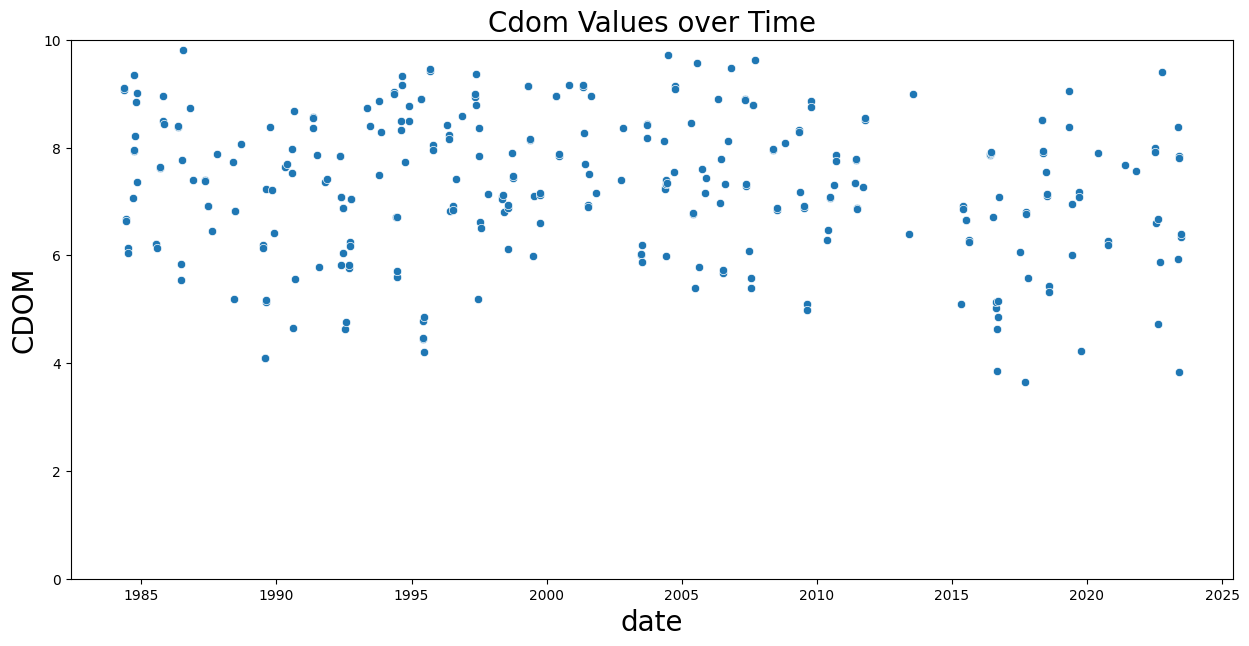

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


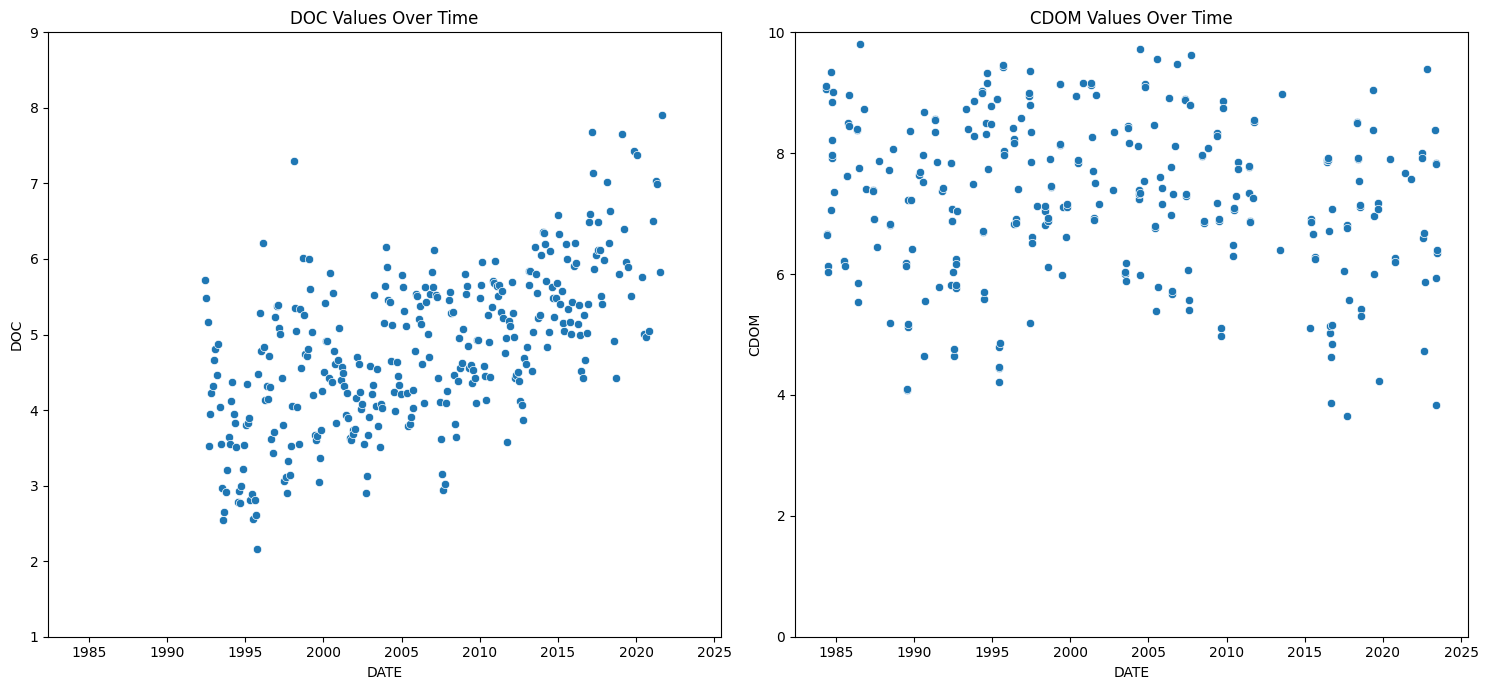

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x='date', y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_ylim(1,9)

ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_ylim(0,10)
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


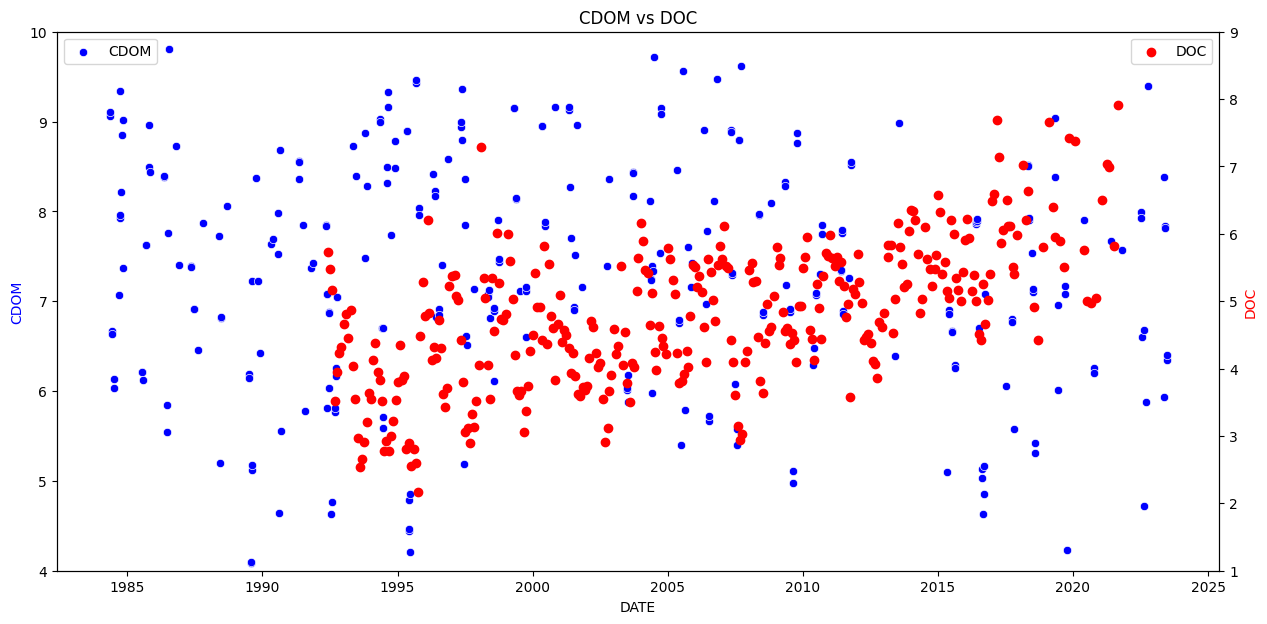

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data['date'], data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(4,10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


In [36]:
print(df['date'].dtype)


object


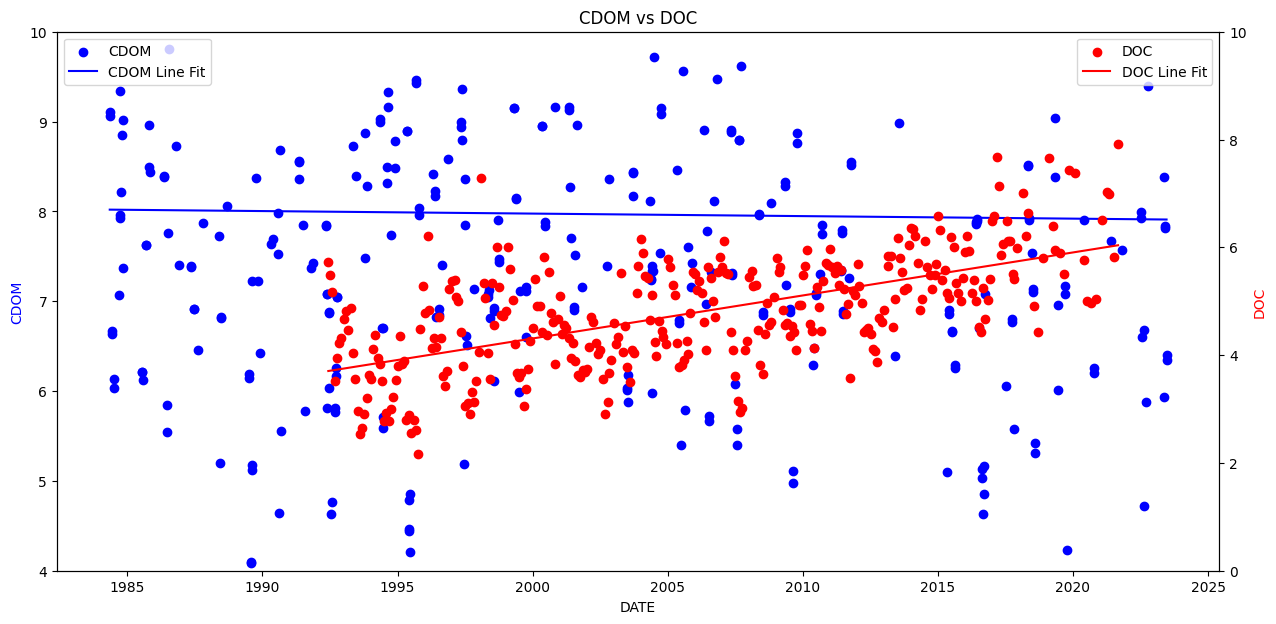

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df['date'] = pd.to_datetime(df['date'])

# Convert the date values to numeric format
df['date_numeric'] = pd.to_numeric(df['date']).astype(float)
data['index_numeric'] = pd.to_numeric(data['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot for CDOM
ax.scatter(df['date'], df['CDOM'], label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data['date'], data['DOC'], label='DOC', color='red')

# Calculate the linear regression line for CDOM
cdom_x = df['date_numeric']
cdom_y = df['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
ax.plot(df['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = data['index_numeric']
doc_y = data['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(data['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


In [38]:
print(doc_slope)

2.528912832332804e-18


In [39]:
data.sort_values('date', inplace=True)

# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])



# Perform inner merge with seven-day window
merged_inner1 = pd.merge_asof(df, data, left_on='date', right_on='date', tolerance=pd.Timedelta(days=3))

#Get rid of the null values from doc
merged_inner1 = merged_inner1.dropna()

#print(merged_inner1)


In [40]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner1 = merged_inner1.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner1)


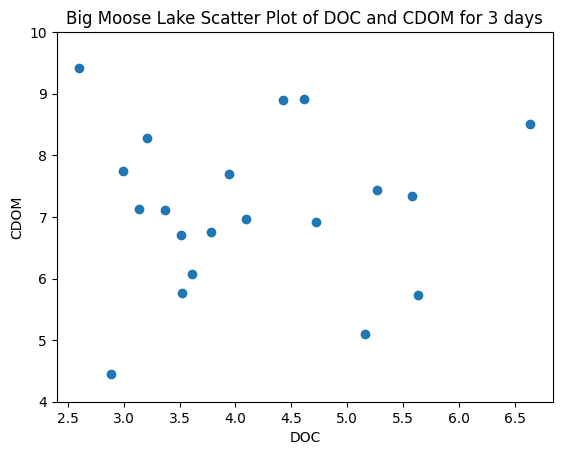

In [41]:
import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.scatter(merged_inner1['DOC'], merged_inner1['CDOM'])

# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('Big Moose Lake Scatter Plot of DOC and CDOM for 3 days')
plt.ylim(4,10)
# Displaying the plot
plt.show()


In [42]:
# Sort the doc DataFrame by date in ascending order

data.sort_values('date', inplace=True)
# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])



# Perform inner merge with seven-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='date', tolerance=pd.Timedelta(days=7))

#Get rid of the null values from doc
merged_inner = merged_inner.dropna()

#print(merged_inner)


In [43]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner)


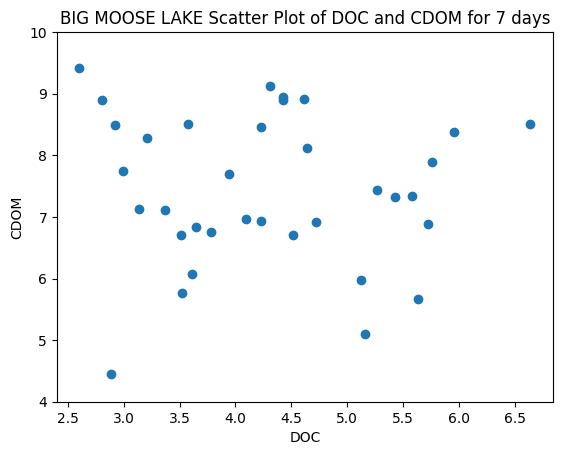

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])
# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('BIG MOOSE LAKE Scatter Plot of DOC and CDOM for 7 days')
plt.ylim(4,10)
# Displaying the plot
plt.show()



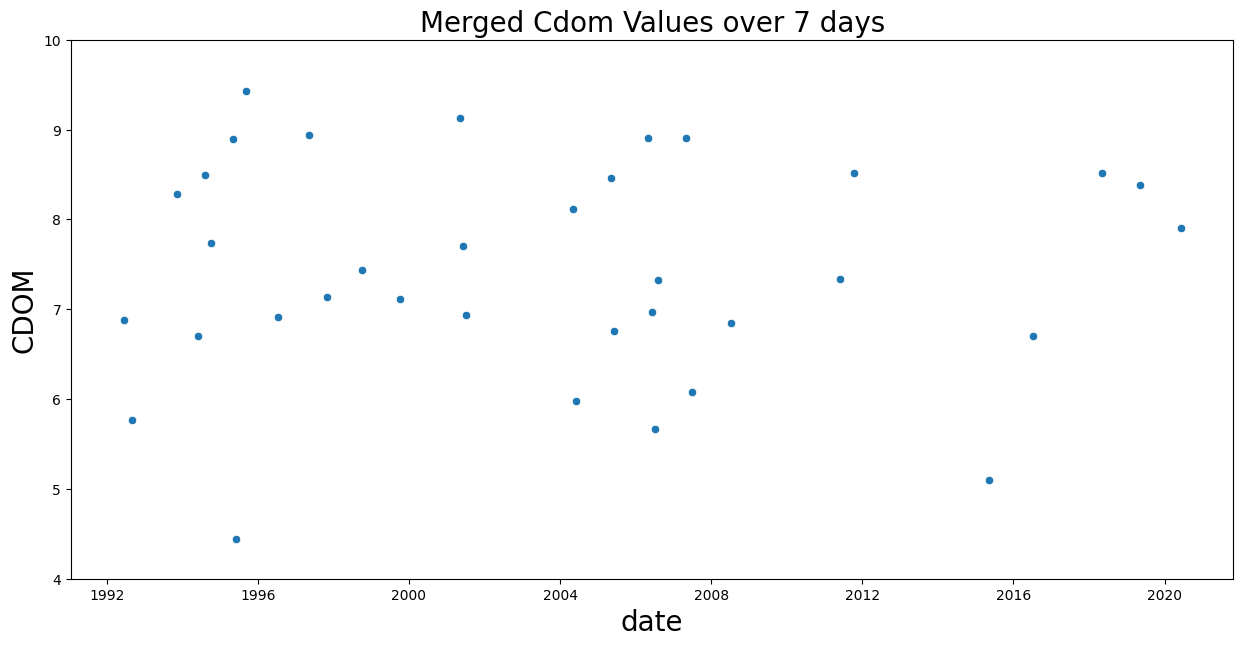

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Merged Cdom Values over 7 days', fontsize=20)
ax.set_ylim(4,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


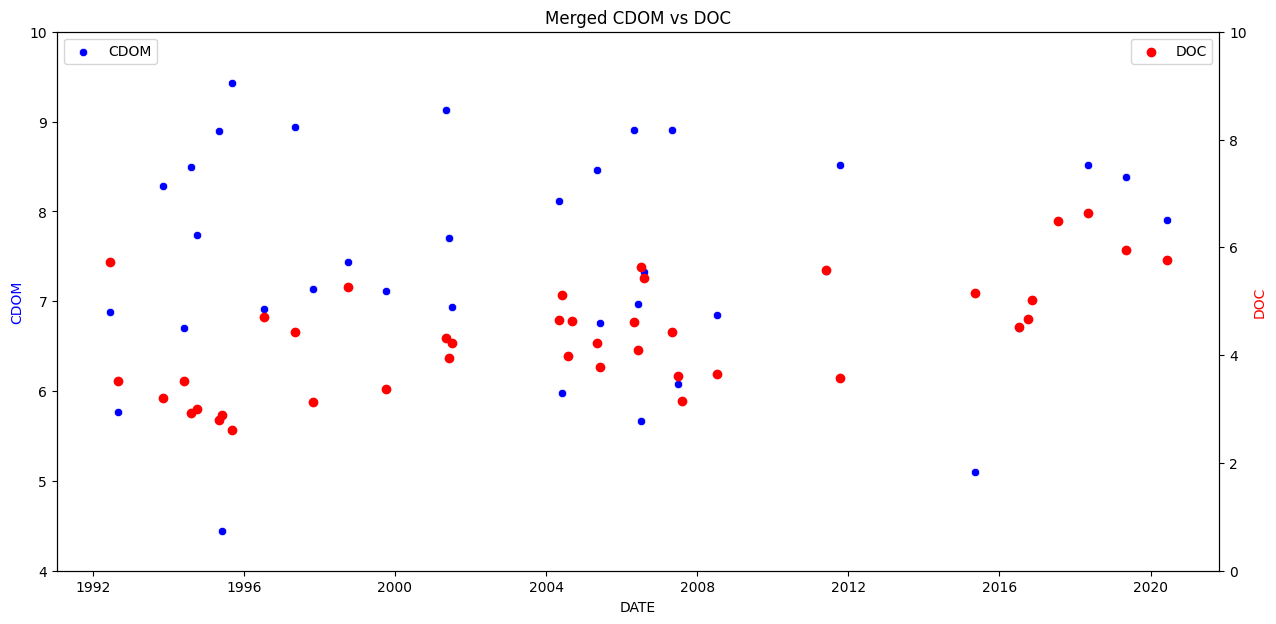

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


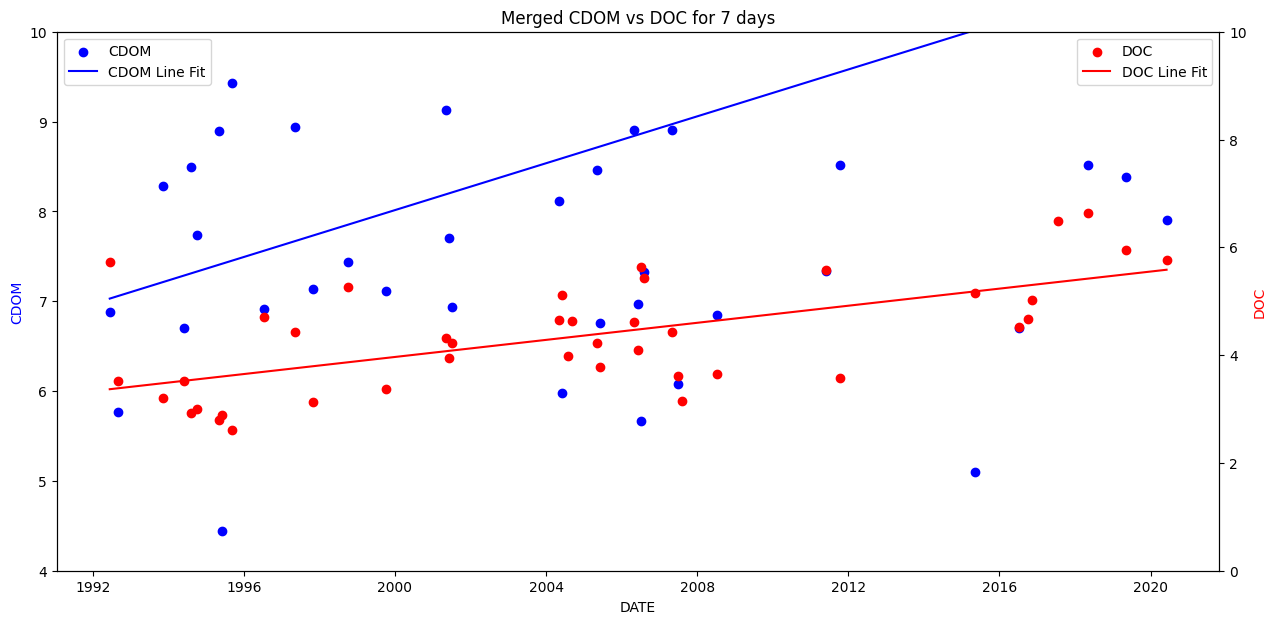

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert the date values to numeric format
merged_inner['date_numeric'] = pd.to_numeric(merged_inner['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot 
ax.scatter(merged_inner['date'], merged_inner['CDOM'], label='CDOM', color='blue')


# Create a twin Axes object for DOC
ax2 = ax.twinx()
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')


# Calculate the linear regression line for CDOM
cdom_x = merged_inner['date_numeric']
cdom_y = merged_inner['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
ax.plot(merged_inner['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = merged_inner['date_numeric']
doc_y = merged_inner['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(merged_inner['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC for 7 days')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


In [31]:
# merged_inner['DOC'].corr(merged_inner['CDOM'])
